# Applicazione degli algoritmi

### Meccanismo per allertarmi via mail della fine dell'esecuzione

In [1]:
from email.message import EmailMessage
import ssl
import smtplib
import credenziali

def invia_mail(body):
    """Funzione per inviare una mail per allertarmi se si è verificato un errore o se l'esecuzione è terminata con 
       successo.
       - body: messaggio nel corpo della mail (String) """

    # mail e password per login mittente
    m_s = credenziali.mail_mitt()
    p_s = credenziali.psw_mitt()

    # mail del destinatario
    m_r = credenziali.mail_dest()
    subject = 'AGGIORNAMENTO STATO ESECUZIONE TESI'
    body = body
    
    # creazione oggetto mail
    email = EmailMessage()
    # inserimento dei dati
    email['From'] = m_s
    email['To'] = m_r
    email['subject'] = subject
    email.set_content(body)
    # creazione del contesto ssl
    context = ssl.create_default_context()
    
    # connessione a server e invio mail
    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as SMTP:
        SMTP.login(m_s, p_s)
        SMTP.sendmail(m_s, m_r, email.as_string())

***
### Importazione dei dati

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.manifold import TSNE
from sklearn.metrics import auc, accuracy_score, roc_curve, recall_score, matthews_corrcoef, f1_score, confusion_matrix
from statistics import mean

import os
import pickle
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
ConvergenceWarning("ignore")

sklearn.exceptions.ConvergenceWarning('ignore')

In [3]:
def importa_dati(path, sep=','):
    """Funzione per l'importazione di un dataset con un formato csv in un DataFrame di Pandas.
       - path: percorso in cui è salvato il file.csv (stringa);
       - sep: separatore utilizzato nel file (stringa)"""
    data = pd.read_csv(path, sep=sep)
    data.drop('Unnamed: 0', axis=1, inplace=True)
    return data

In [4]:
# IMPORTAZIONE DATASETS COMPLETI
# versione multiclasse
df_ohe_multi = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_OHE_MULTI.csv')
df_le_multi = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_LE_MULTI.csv')
# version binaria
df_ohe_bin = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_OHE_BIN.csv')
df_le_bin = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_LE_BIN.csv')

# IMPORTAZIONE DATASETS SENZA COLONNE RELATIVE ALLE SOMMINISTRAZIONI
# versione multiclasse
df_ohe_multi_no_somm = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_OHE_MULTI_no_somm.csv')
df_le_multi_no_somm = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_LE_MULTI_no_somm.csv')
# version binaria
df_ohe_bin_no_somm = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_OHE_BIN_no_somm.csv')
df_le_bin_no_somm = importa_dati('/Users/eliaceccolini/Documents/Uni/Tesi/Dataset_finale/Datasets/Dataset_preprocessato_LE_BIN_no_somm.csv')

***
### Divisione della variabile risposta dalle feature

In [5]:
def estrapola_variabile_risposta(data, var):
    """Funzione per dividere il dataset in X e y, quindi per separare la variabile risposta dalle feature.
       - data: Dataset (DataFrame)
       - var: nome della variabile risposta (String)"""
    y = data[var]
    X = data.drop(var, axis=1)
    return X, y

In [6]:
# DATASETS COMPLETI
# versione multi-classe
X_le_multi, y_le_multi = estrapola_variabile_risposta(df_le_multi, 'best_response')
X_ohe_multi, y_ohe_multi = estrapola_variabile_risposta(df_ohe_multi, 'best_response')
# versione binaria
X_le_bin, y_le_bin = estrapola_variabile_risposta(df_le_bin, 'best_response')
X_ohe_bin, y_ohe_bin = estrapola_variabile_risposta(df_ohe_bin, 'best_response')

# DATASETS SENZA COLONNE RELATIVE ALLE SOMMINISTRAZIONI
# versione multi-classe
X_le_multi_no_somm, y_le_multi_no_somm = estrapola_variabile_risposta(df_le_multi_no_somm, 'best_response')
X_ohe_multi_no_somm, y_ohe_multi_no_somm = estrapola_variabile_risposta(df_ohe_multi_no_somm, 'best_response')
# versione binaria
X_le_bin_no_somm, y_le_bin_no_somm = estrapola_variabile_risposta(df_le_bin_no_somm, 'best_response')
X_ohe_bin_no_somm, y_ohe_bin_no_somm = estrapola_variabile_risposta(df_ohe_bin_no_somm, 'best_response')

***
### Funzione per eseguire cross validation e salvare i relativi grafici

In [7]:
def classificazione_crossvalidate(X, y, exp_name, num_trials, p_grid, model=None, model_name=None):
    """Funzione per evidenziare la t-distributed stochastic neighbor embedding del dataset in due dimensioni
       e per applicare il modello model_name al dataset per predire y a partire dalle feature X.
       - X: feature usate per la predizione di y (DataFrame)
       - y: variabile risposta (Series)
       - exp_name: nome dell'esperimento (String)
       - num_trials: numero di iterazioni da effettuare per la predizione (int)
       - p_grid: parametri della griglia (Dictionary)
       - model: modello ML da utilizzare
       - model_name: nome del modello (String)"""
    
    # visualizzazione del dataset in uno spazio bidimensionale (tsne)
    np.random.seed(1)
    tsne = TSNE(n_components=2, verbose=0, random_state=123)
    z = tsne.fit_transform(X)
    df = pd.DataFrame()
    df["y"] = y
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]
    plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),data=df)
    plt.title("TSNE_"+exp_name)
    plt.savefig("immagini/tsne/TSNE_"+ exp_name +".png", dpi=600)
    plt.close()
    
    # divisione del datset in train e test
    X, X_test_final, y, y_test_final = train_test_split(X, y, test_size=0.33, random_state=1)
    
    # score che verranno considerati
    myscoring = ['balanced_accuracy', 'roc_auc', 'average_precision', 'recall']
    
    # inizializzazione dei vettori per i punteggi nel train set
    nested_scores = np.zeros(num_trials)
    bal_acc_train_scores = np.zeros((num_trials,1))
    roc_auc_train_scores = np.zeros((num_trials,1))
    ave_pre_train_scores = np.zeros((num_trials,1))
    recall_train_scores = np.zeros((num_trials,1))
    # inizializzazione dei vettori per i punteggi nel test set
    bal_acc_test_scores = np.zeros((num_trials,1))
    roc_auc_test_scores = np.zeros((num_trials,1))
    ave_pre_test_scores = np.zeros((num_trials,1))
    recall_test_scores = np.zeros((num_trials,1))
    
    # inizio iterazioni
    for i in range(num_trials):
        print('Iterazione numero '+str(i))
        np.random.seed(i)
        cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
        cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
        # definizione griglia
        clf = GridSearchCV(model, p_grid, scoring='recall', n_jobs=1, cv=cv_inner, refit=True, return_train_score=True)
        # esecuzione della cross validation innestata
        scores = cross_validate(clf, X=X, y=y, cv=cv_outer, return_train_score=True, return_estimator=True, scoring=myscoring)
        
        # salvataggio e stampa dei risultati all'i-esima iterazione
        bal_acc_train_scores[i] = np.mean(scores['train_balanced_accuracy'])
        roc_auc_train_scores[i] = np.mean(scores['train_roc_auc'])
        ave_pre_train_scores[i] = np.mean(scores['train_average_precision'])
        recall_train_scores[i] = np.mean(scores['train_recall'])
        print('Train: balanced_accuracy ' + str( bal_acc_train_scores[i]))
        print('Train: roc_auc ' + str(roc_auc_train_scores[i]))
        print('Train: average_precision ' + str(ave_pre_train_scores[i]))
        print('Train: recall ' + str(recall_train_scores[i]))
        bal_acc_test_scores[i] = np.mean(scores['test_balanced_accuracy'])
        roc_auc_test_scores[i] = np.mean(scores['test_roc_auc'])
        ave_pre_test_scores[i] = np.mean(scores['test_average_precision'])
        recall_test_scores[i] = np.mean(scores['test_recall'])
        print('Test: balanced_accuracy ' + str( bal_acc_test_scores[i]))
        print('Test: roc_auc ' + str(roc_auc_test_scores[i]))
        print('Test: average_precision ' + str(ave_pre_test_scores[i]))
        print('Test: recall ' + str(recall_test_scores[i]))
        
        # fpr: tasso falsi positivi, tpr: tasso veri positivi
        mean_fpr = np.linspace(0, 1, 1000)
        tprs = []
        # divisione train e test set
        for j, (train_ix, test_ix) in enumerate(cv_inner.split(X, y)):
            X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
            y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
            classifier_fold = scores['estimator'][j].best_estimator_
            classifier_fold.fit(X_train, y_train)
            y_pred_labels = classifier_fold.predict(X_test)
            # rapporto falsi positivi e veri positivi e soglia utilizzata per il loro calcolo
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_labels)
            # calcolo area sotto la curva
            roc_auc = auc(fpr, tpr)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
        
        # plot ROC AUC medie
        plt.figure()
        plt.plot([0, 1], [0, 1], '--', color='r', label='Random classifier', lw=2, alpha=0.8)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.title('Mean AUC=%0.3f' % mean_auc)
        plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC', lw=2, alpha=0.8)

        ## calcolo deviazione standard
        std_tpr = np.std(tprs, axis=0)
        tprs_upper_std = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower_std = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower_std, tprs_upper_std, color='green', alpha=.2,label=r'$\pm$ 1 SD')

        ## calcolo 99.9% CI
        z = 3.291
        SE = std_tpr / np.sqrt(num_trials * 5)
        tprs_upper_95CI = mean_tpr + (z * SE)
        tprs_lower_95CI = mean_tpr - (z * SE)
        plt.fill_between(mean_fpr, tprs_lower_95CI, tprs_upper_95CI, color='grey', alpha=.5,label=r'$\pm$ 99.9% CI')
        
        # salvataggio curva ROC
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Tasso di Falsi Positivi')
        plt.ylabel('Tasso di Veri Positivi')
        plt.legend(loc="lower right")
        plt.savefig("immagini/ROCcurves/ROCcurve_" + exp_name + "_" + model_name + ".png", dpi=600)
        plt.close()

    mean_results_matrix = np.zeros((3,2))

    train_accuracy_global_mean = np.mean(bal_acc_train_scores)
    train_accuracy_global_std = np.std(bal_acc_train_scores)

    test_accuracy_global_mean = np.mean(bal_acc_test_scores)
    test_accuracy_global_std = np.std(bal_acc_test_scores)
    mean_results_matrix[0,0] = test_accuracy_global_mean
    mean_results_matrix[0,1] = test_accuracy_global_std

    roc_auc_global_test_mean = np.mean(roc_auc_test_scores)
    roc_auc_global_test_std = np.std(roc_auc_test_scores)
    mean_results_matrix[1,0] = roc_auc_global_test_mean
    mean_results_matrix[1,1] = roc_auc_global_test_std

    test_recall_global_mean = np.mean(recall_test_scores)
    test_recall_global_std = np.std(recall_test_scores)
    mean_results_matrix[2,0] = test_recall_global_mean
    mean_results_matrix[2,1] = test_recall_global_std

    mean_results_df = pd.DataFrame(data=mean_results_matrix, columns=["mean","std"], index=["Test accuracy","Test ROC AUC","Test recall"])
    os.makedirs("risultati", exist_ok=True)
    mean_results_df.to_html("risultati/Mean_Results_"+ exp_name + "_" + model_name +".html")


    print("Train accuracy mean: " + str(train_accuracy_global_mean) + " std: " + str(train_accuracy_global_std))
    print("Test ROC AUC mean: " + str(roc_auc_global_test_mean) + " std: " + str(roc_auc_global_test_std))
    print("Test accuracy mean: " + str(test_accuracy_global_mean) + " std: " + str(test_accuracy_global_std))
    print("Test recall mean: " + str(test_recall_global_mean) + " std: " + str(test_recall_global_std))


    # modello finale
    print("Training final classifier...")
    clf_final = GridSearchCV(estimator=model, param_grid=p_grid, scoring='recall', 
                             n_jobs=-1, refit=True, cv=cv_inner, verbose=0, return_train_score=True)
    clf_final.fit(X,y)
    best_model = clf_final.best_estimator_
    print("Best final estimator:")
    print(best_model)
    
    # se il modello è un albero o un random forest vengono stampate e salvate le var più significative
    if 'Tree' in model_name or 'Forest' in model_name or 'XGBoost' in model_name:
        feature_names = X.columns
        feature_importances = best_model.feature_importances_
        # Ordinare le feature per importanza in modo decrescente e selezionare solo le prime 10
        top_10_indices = feature_importances.argsort()[::-1][:10]
        top_10_importances = feature_importances[top_10_indices]
        top_10_feature_names = feature_names[top_10_indices]
        plt.figure()
        plt.barh(range(len(top_10_importances)), top_10_importances, align='center')
        plt.yticks(range(len(top_10_importances)), top_10_feature_names)
        plt.xlabel('Importanza delle variabili')
        plt.ylabel('Variabili')
        plt.title('Importanza_variabili_'+exp_name)
        plt.tight_layout()
        plt.savefig('immagini/importanza_variabili/Importanza_variabili_'+exp_name+'.png', dpi=600)
        
    # se il modello è un SVM vengono stampati e salvati i pesi relativi alle var più significative
    if 'SVM' in model_name:
        coefficients = abs(best_model.coef_[0])
        # associazione dei coefficienti alle variabili
        variable_coefficients = list(zip(X_train.columns, coefficients))
        # ordinamento in ordine decrescente delle variabili in base al valore assoluto del peso assegnotogli
        variable_coefficients.sort(key=lambda x: x[1], reverse=True)
        top_10_variables = variable_coefficients[:10]
        # Estrazione delle variabili e coefficienti per il grafico
        variables, coefficients = zip(*top_10_variables)
        plt.figure()
        plt.barh(range(len(variables)), coefficients, align='center')
        plt.yticks(range(len(variables)), variables)
        plt.xlabel('Peso')
        plt.ylabel('Variabile')
        plt.title('Le prime 10 variabili più importanti')
        plt.tight_layout()
        plt.savefig('immagini/importanza_variabili/Importanza_variabili_'+exp_name+'.png', dpi=600)
    
        
    # se il modello è un albero viene stampata e salvata la struttura dell'albero decisionale
    if 'Tree' in model_name:
        plt.figure()
        plot_tree(decision_tree=best_model, feature_names=list(X.columns))
        plt.title('albero_decisionale_'+exp_name)
        plt.savefig('immagini/alberi_decisionali/Albero_decisionale_'+exp_name+'.png', dpi=600)
    
    # salvataggio del modello allenato
    os.makedirs("modelli", exist_ok=True)
    pickle.dump(best_model, open("modelli/Modello_"+ exp_name + "_" + model_name +".pkl",'wb'))
    
    # predizione del test set
    y_final_pred_labels = best_model.predict(X_test_final)
    final_model_accuracy = accuracy_score(y_test_final, y_final_pred_labels)
    # stampa dei punteggi finali
    print("Final estimator accuracy: " + str(final_model_accuracy))
    fpr, tpr, thresholds = roc_curve(y_test_final, y_final_pred_labels)
    roc_auc = auc(fpr, tpr)
    print("roc_auc final model: " + str(np.round(roc_auc,3)))
    final_model_recall = recall_score(y_test_final, y_final_pred_labels)
    print("Final estimator recall: " + str(final_model_recall))
    final_model_matt_corrcoef = matthews_corrcoef(y_test_final, y_final_pred_labels)
    print("Final estimator Matthews Correlation Coefficient: " + str(final_model_matt_corrcoef))
    final_model_f1score = f1_score(y_test_final, y_final_pred_labels)
    print("Final estimator F1 score: " + str(final_model_f1score))
    
    # stampa e salvataggio della matrice di confusione
    conf_matrix = confusion_matrix(y_test_final, y_final_pred_labels)
    plt.figure()
    plt.title('Matrice_Confusione_' + exp_name)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.savefig('immagini/matrici_confusione/Matrice_confusione_'+exp_name+'.png', dpi=600)
    
    return final_model_accuracy, roc_auc, final_model_recall, final_model_f1score, final_model_matt_corrcoef

***
### Applicazione modelli (versione binaria)
I modelli che saranno applicati sono:
- Naive Bayes
- Decision Tree Classifier
- Random Forest Classifier
- SVM
- XGBoost
- MLP Classifier - Multi-Layer Perceptron Classifier

In [8]:
def applica_modelli(X, y, exp_name, num_trials):
    """Funzione per applicare i modelli Naive Bayes, Decision Tree Classifier, Random Forest, SVM, XGBoost e MLP
       al dataset data.
       - X: feature del dataset (DataFrame)
       - y: variabile risposta (Series)
       - exp_name: nome esperimento (String)
       - num_trials: numero di iterazioni (Int)"""
    
    res = np.zeros((6, 5))
    
    # Naive Bayes
    try:
        p_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
        model = GaussianNB()
        model_name = 'NaiveBayes'
        acc, roc_auc, recall, f1score, marr_corrcoef = classificazione_crossvalidate(X, y, 'NB_'+exp_name, num_trials, p_grid, model, model_name)
        res[0] = [acc, roc_auc, recall, f1score, marr_corrcoef]
    except Exception as e:
        invia_mail("Errore durante l'esecuzione del modello " + model_name)
        print(e)
    
    # Decision Tree Classifier
    try:
        p_grid = {"criterion":['gini','entropy'], "max_depth":[2,4,6,8,10,12]}
        model = DecisionTreeClassifier()
        model_name = 'DecisionTree'
        acc, roc_auc, recall, f1score, marr_corrcoef = classificazione_crossvalidate(X, y, 'DT_'+exp_name, num_trials, p_grid, model, model_name)
        res[1] = [acc, roc_auc, recall, f1score, marr_corrcoef]
    except Exception as e:
        invia_mail("Errore durante l'esecuzione del modello " + model_name)
        print(e)
    
    # Random Forest Classifier
    try:
        p_grid = {'n_estimators': [5, 10, 15, 20], 'max_depth': [2, 5, 7, 9]}
        model = RandomForestClassifier()
        model_name = 'RandomForest'
        acc, roc_auc, recall, f1score, marr_corrcoef = classificazione_crossvalidate(X, y, 'RF_'+exp_name, num_trials, p_grid, model, model_name)
        res[2] = [acc, roc_auc, recall, f1score, marr_corrcoef]
    except Exception as e:
        invia_mail("Errore durante l'esecuzione del modello " + model_name)
        print(e)
    
    # SVM
    try:
        p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}
        model = SVC(kernel="linear", max_iter=100)
        model_name = 'SVM'
        acc, roc_auc, recall, f1score, marr_corrcoef = classificazione_crossvalidate(X, y, 'SVM_'+exp_name, num_trials, p_grid, model, model_name)
        res[3] = [acc, roc_auc, recall, f1score, marr_corrcoef]
    except Exception as e:
        invia_mail("Errore durante l'esecuzione del modello " + model_name)
        print(e)
    
    # XGBoost - le iterazioni sono due perché impiega più di 3 ore con cinquanta
    try:
        p_grid = {"gamma":[0, 0.1, 0.2,0.3,0.4,0.5],
                  "max_depth": [3,5,10],
                  "n_estimators":[5,10, 20, 100],
                  "ubsample": [0.25, 0.5, 1],
                  "verbosity": [0]}
        model = XGBClassifier(silent=True)
        model_name = 'XGBoost'
        acc, roc_auc, recall, f1score, marr_corrcoef = classificazione_crossvalidate(X, y, 'XGBoost_'+exp_name, 2, p_grid, model, model_name)
        res[4] = [acc, roc_auc, recall, f1score, marr_corrcoef]
    except Exception as e:
        invia_mail("Errore durante l'esecuzione del modello " + model_name)
        print(e)
    
    # MLP
    try:
        p_grid = {"hidden_layer_sizes": [(10,30,10),(20,)],
                  "activation": ["tanh", "relu"],
                  "solver": ["sgd", "adam"],
                  "alpha": [0.0001, 0.05],
                  "learning_rate": ["constant","adaptive"]}
        model = MLPClassifier(max_iter=100)
        model_name = 'MLP'
        acc, roc_auc, recall, f1score, marr_corrcoef = classificazione_crossvalidate(X, y, 'MLP_'+exp_name, num_trials, p_grid, model, model_name)
        res[5] = [acc, roc_auc, recall, f1score, marr_corrcoef]
    except Exception as e:
        invia_mail("Errore durante l'esecuzione del modello " + model_name)
        print(e)
    
    return res

In [10]:
# APPLICAZIONE SU DATASET COMPLETO
# esperimento: dataset pre-processato con LE nella versione binaria
#scores_le_bin = applica_modelli(X_le_bin, y_le_bin, 'LE_BIN', 50)
# esperimento: dataset pre-processato con OHE nella versione binaria
#scores_ohe_bin = applica_modelli(X_ohe_bin, y_ohe_bin, 'OHE_BIN', 50)
# invio mail per allertare che l'esecuzione è terminata con successo 
#invia_mail('Esecuzione terminata con successo!')

Iterazione numero 0
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balanced_accuracy [0.62788683]
Test: roc_auc [0.67185789]
Test: average_precision [0.71677234]
Test: recall [0.67144325]
Iterazione numero 1
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balanced_accuracy [0.62788683]
Test: roc_auc [0.67185789]
Test: average_precision [0.71677234]
Test: recall [0.67144325]
Iterazione numero 2
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balanced_accuracy [0.62788683]
Test: roc_auc [0.67185789]
Test: average_precision [0.71677234]
Test: recall [0.67144325]
Iterazione numero 3
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balanced_

Iterazione numero 30
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balanced_accuracy [0.62788683]
Test: roc_auc [0.67185789]
Test: average_precision [0.71677234]
Test: recall [0.67144325]
Iterazione numero 31
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balanced_accuracy [0.62788683]
Test: roc_auc [0.67185789]
Test: average_precision [0.71677234]
Test: recall [0.67144325]
Iterazione numero 32
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balanced_accuracy [0.62788683]
Test: roc_auc [0.67185789]
Test: average_precision [0.71677234]
Test: recall [0.67144325]
Iterazione numero 33
Train: balanced_accuracy [0.63653864]
Train: roc_auc [0.70085038]
Train: average_precision [0.72303081]
Train: recall [0.67316736]
Test: balan

Iterazione numero 8
Train: balanced_accuracy [0.7216878]
Train: roc_auc [0.76665753]
Train: average_precision [0.75808421]
Train: recall [0.8433694]
Test: balanced_accuracy [0.60716422]
Test: roc_auc [0.6190599]
Test: average_precision [0.63206151]
Test: recall [0.71063872]
Iterazione numero 9
Train: balanced_accuracy [0.7216878]
Train: roc_auc [0.76665753]
Train: average_precision [0.75808421]
Train: recall [0.8433694]
Test: balanced_accuracy [0.60446151]
Test: roc_auc [0.61435519]
Test: average_precision [0.62944993]
Test: recall [0.71063872]
Iterazione numero 10
Train: balanced_accuracy [0.7216878]
Train: roc_auc [0.76665753]
Train: average_precision [0.75808421]
Train: recall [0.8433694]
Test: balanced_accuracy [0.61113008]
Test: roc_auc [0.62502776]
Test: average_precision [0.63606368]
Test: recall [0.72116503]
Iterazione numero 11
Train: balanced_accuracy [0.7216878]
Train: roc_auc [0.76665753]
Train: average_precision [0.75808421]
Train: recall [0.8433694]
Test: balanced_accurac

Iterazione numero 38
Train: balanced_accuracy [0.71693574]
Train: roc_auc [0.76628813]
Train: average_precision [0.75759482]
Train: recall [0.83882395]
Test: balanced_accuracy [0.59790106]
Test: roc_auc [0.61053358]
Test: average_precision [0.62796335]
Test: recall [0.7001124]
Iterazione numero 39
Train: balanced_accuracy [0.7216878]
Train: roc_auc [0.76665753]
Train: average_precision [0.75808421]
Train: recall [0.8433694]
Test: balanced_accuracy [0.60716422]
Test: roc_auc [0.6190599]
Test: average_precision [0.63206151]
Test: recall [0.71063872]
Iterazione numero 40
Train: balanced_accuracy [0.7526121]
Train: roc_auc [0.80210988]
Train: average_precision [0.79274865]
Train: recall [0.82168109]
Test: balanced_accuracy [0.58916965]
Test: roc_auc [0.60659336]
Test: average_precision [0.62631359]
Test: recall [0.65169135]
Iterazione numero 41
Train: balanced_accuracy [0.71693574]
Train: roc_auc [0.76628813]
Train: average_precision [0.75759482]
Train: recall [0.83882395]
Test: balanced_a

Iterazione numero 16
Train: balanced_accuracy [0.67495521]
Train: roc_auc [0.75030638]
Train: average_precision [0.77123638]
Train: recall [0.80104793]
Test: balanced_accuracy [0.58426287]
Test: roc_auc [0.62591138]
Test: average_precision [0.68466625]
Test: recall [0.73458495]
Iterazione numero 17
Train: balanced_accuracy [0.7170321]
Train: roc_auc [0.80224851]
Train: average_precision [0.82004729]
Train: recall [0.84586969]
Test: balanced_accuracy [0.59950231]
Test: roc_auc [0.67250998]
Test: average_precision [0.67719828]
Test: recall [0.72628389]
Iterazione numero 18
Train: balanced_accuracy [0.74050588]
Train: roc_auc [0.81476304]
Train: average_precision [0.82514771]
Train: recall [0.84062048]
Test: balanced_accuracy [0.5840581]
Test: roc_auc [0.63154094]
Test: average_precision [0.69055839]
Test: recall [0.68654464]
Iterazione numero 19
Train: balanced_accuracy [0.66781713]
Train: roc_auc [0.7633785]
Train: average_precision [0.7923119]
Train: recall [0.83164021]
Test: balanced_

Iterazione numero 46
Train: balanced_accuracy [0.71534362]
Train: roc_auc [0.79314391]
Train: average_precision [0.8120514]
Train: recall [0.80714872]
Test: balanced_accuracy [0.62951181]
Test: roc_auc [0.63317282]
Test: average_precision [0.67847622]
Test: recall [0.71721526]
Iterazione numero 47
Train: balanced_accuracy [0.72853296]
Train: roc_auc [0.80584021]
Train: average_precision [0.83454199]
Train: recall [0.83001072]
Test: balanced_accuracy [0.61086928]
Test: roc_auc [0.67973653]
Test: average_precision [0.71139216]
Test: recall [0.72142781]
Iterazione numero 48
Train: balanced_accuracy [0.70665188]
Train: roc_auc [0.79637579]
Train: average_precision [0.81973415]
Train: recall [0.81552994]
Test: balanced_accuracy [0.61385508]
Test: roc_auc [0.64687459]
Test: average_precision [0.6942523]
Test: recall [0.71535354]
Iterazione numero 49
Train: balanced_accuracy [0.66715763]
Train: roc_auc [0.75508923]
Train: average_precision [0.77752679]
Train: recall [0.75231987]
Test: balance

Iterazione numero 24
Train: balanced_accuracy [0.53139758]
Train: roc_auc [0.56479251]
Train: average_precision [0.62410663]
Train: recall [0.520788]
Test: balanced_accuracy [0.52260192]
Test: roc_auc [0.54375793]
Test: average_precision [0.61167004]
Test: recall [0.47708919]
Iterazione numero 25
Train: balanced_accuracy [0.53139758]
Train: roc_auc [0.56479251]
Train: average_precision [0.62410663]
Train: recall [0.520788]
Test: balanced_accuracy [0.52260192]
Test: roc_auc [0.54375793]
Test: average_precision [0.61167004]
Test: recall [0.47708919]
Iterazione numero 26
Train: balanced_accuracy [0.53139758]
Train: roc_auc [0.56479251]
Train: average_precision [0.62410663]
Train: recall [0.520788]
Test: balanced_accuracy [0.52260192]
Test: roc_auc [0.54375793]
Test: average_precision [0.61167004]
Test: recall [0.47708919]
Iterazione numero 27
Train: balanced_accuracy [0.53139758]
Train: roc_auc [0.56479251]
Train: average_precision [0.62410663]
Train: recall [0.520788]
Test: balanced_accu

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Con

Final estimator accuracy: 0.4358974358974359
roc_auc final model: 0.437
Final estimator recall: 0.5584415584415584
Final estimator Matthews Correlation Coefficient: -0.12897747651766098
Final estimator F1 score: 0.49425287356321845
Iterazione numero 0
Train: balanced_accuracy [0.89032129]
Train: roc_auc [0.92970805]
Train: average_precision [0.93579157]
Train: recall [0.93047706]
Test: balanced_accuracy [0.58498498]
Test: roc_auc [0.61282597]
Test: average_precision [0.66651103]
Test: recall [0.63988456]
Iterazione numero 1
Train: balanced_accuracy [0.89032129]
Train: roc_auc [0.92970805]
Train: average_precision [0.93579157]
Train: recall [0.93047706]
Test: balanced_accuracy [0.58498498]
Test: roc_auc [0.61282597]
Test: average_precision [0.66651103]
Test: recall [0.63988456]
Train accuracy mean: 0.8903212883391463 std: 0.0
Test ROC AUC mean: 0.6128259744951474 std: 0.0
Test accuracy mean: 0.584984984984985 std: 0.0
Test recall mean: 0.6398845598845598 std: 0.0
Training final classifi

Iterazione numero 23
Train: balanced_accuracy [0.6372439]
Train: roc_auc [0.67738387]
Train: average_precision [0.69487498]
Train: recall [0.84239191]
Test: balanced_accuracy [0.61807394]
Test: roc_auc [0.64409369]
Test: average_precision [0.65915698]
Test: recall [0.8089856]
Iterazione numero 24
Train: balanced_accuracy [0.63076512]
Train: roc_auc [0.69933165]
Train: average_precision [0.71379868]
Train: recall [0.80088427]
Test: balanced_accuracy [0.63795287]
Test: roc_auc [0.67892891]
Test: average_precision [0.69304523]
Test: recall [0.81440065]
Iterazione numero 25
Train: balanced_accuracy [0.60176461]
Train: roc_auc [0.65025775]
Train: average_precision [0.67334396]
Train: recall [0.68697978]
Test: balanced_accuracy [0.56449288]
Test: roc_auc [0.62660486]
Test: average_precision [0.66072444]
Test: recall [0.66757145]
Iterazione numero 26
Train: balanced_accuracy [0.58086351]
Train: roc_auc [0.6004152]
Train: average_precision [0.62067512]
Train: recall [0.82530759]
Test: balanced

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

Best final estimator:
MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(10, 30, 10),
              max_iter=100, solver='sgd')
Final estimator accuracy: 0.4807692307692308
roc_auc final model: 0.484
Final estimator recall: 0.7662337662337663
Final estimator Matthews Correlation Coefficient: -0.03782468490518602
Final estimator F1 score: 0.5929648241206031
Iterazione numero 0
Train: balanced_accuracy [0.64780945]
Train: roc_auc [0.71106728]
Train: average_precision [0.72429064]
Train: recall [0.68419161]
Test: balanced_accuracy [0.6249946]
Test: roc_auc [0.67882367]
Test: average_precision [0.72666576]
Test: recall [0.65765879]
Iterazione numero 1
Train: balanced_accuracy [0.64780945]
Train: roc_auc [0.71106728]
Train: average_precision [0.72429064]
Train: recall [0.68419161]
Test: balanced_accuracy [0.6249946]
Test: roc_auc [0.67882367]
Test: average_precision [0.72666576]
Test: recall [0.65765879]
Iterazione numero 2
Train: balanced_accuracy [0.64780945]
Train: roc_auc 

Iterazione numero 29
Train: balanced_accuracy [0.64780945]
Train: roc_auc [0.71106728]
Train: average_precision [0.72429064]
Train: recall [0.68419161]
Test: balanced_accuracy [0.6249946]
Test: roc_auc [0.67882367]
Test: average_precision [0.72666576]
Test: recall [0.65765879]
Iterazione numero 30
Train: balanced_accuracy [0.64780945]
Train: roc_auc [0.71106728]
Train: average_precision [0.72429064]
Train: recall [0.68419161]
Test: balanced_accuracy [0.6249946]
Test: roc_auc [0.67882367]
Test: average_precision [0.72666576]
Test: recall [0.65765879]
Iterazione numero 31
Train: balanced_accuracy [0.64780945]
Train: roc_auc [0.71106728]
Train: average_precision [0.72429064]
Train: recall [0.68419161]
Test: balanced_accuracy [0.6249946]
Test: roc_auc [0.67882367]
Test: average_precision [0.72666576]
Test: recall [0.65765879]
Iterazione numero 32
Train: balanced_accuracy [0.64780945]
Train: roc_auc [0.71106728]
Train: average_precision [0.72429064]
Train: recall [0.68419161]
Test: balanced

Iterazione numero 7
Train: balanced_accuracy [0.74839867]
Train: roc_auc [0.79607652]
Train: average_precision [0.78400876]
Train: recall [0.83462481]
Test: balanced_accuracy [0.62472627]
Test: roc_auc [0.62216593]
Test: average_precision [0.62187211]
Test: recall [0.69274398]
Iterazione numero 8
Train: balanced_accuracy [0.7559537]
Train: roc_auc [0.79970557]
Train: average_precision [0.78945652]
Train: recall [0.83462481]
Test: balanced_accuracy [0.61116008]
Test: roc_auc [0.60637327]
Test: average_precision [0.61852096]
Test: recall [0.675551]
Iterazione numero 9
Train: balanced_accuracy [0.75809656]
Train: roc_auc [0.80175993]
Train: average_precision [0.79109069]
Train: recall [0.83891053]
Test: balanced_accuracy [0.58991796]
Test: roc_auc [0.58693313]
Test: average_precision [0.59946818]
Test: recall [0.65449837]
Iterazione numero 10
Train: balanced_accuracy [0.73224256]
Train: roc_auc [0.781216]
Train: average_precision [0.76786495]
Train: recall [0.80042568]
Test: balanced_accu

Iterazione numero 37
Train: balanced_accuracy [0.72540502]
Train: roc_auc [0.78471847]
Train: average_precision [0.77323851]
Train: recall [0.84319291]
Test: balanced_accuracy [0.63290809]
Test: roc_auc [0.62745634]
Test: average_precision [0.62361603]
Test: recall [0.73941065]
Iterazione numero 38
Train: balanced_accuracy [0.74323338]
Train: roc_auc [0.79357839]
Train: average_precision [0.78085126]
Train: recall [0.82098845]
Test: balanced_accuracy [0.61583726]
Test: roc_auc [0.61961067]
Test: average_precision [0.62279717]
Test: recall [0.68362117]
Iterazione numero 39
Train: balanced_accuracy [0.72604422]
Train: roc_auc [0.77763473]
Train: average_precision [0.76361225]
Train: recall [0.77315295]
Test: balanced_accuracy [0.60850393]
Test: roc_auc [0.62705671]
Test: average_precision [0.62406395]
Test: recall [0.67695451]
Iterazione numero 40
Train: balanced_accuracy [0.75009971]
Train: roc_auc [0.79842207]
Train: average_precision [0.7875124]
Train: recall [0.83613996]
Test: balanc

Iterazione numero 15
Train: balanced_accuracy [0.63090368]
Train: roc_auc [0.75141337]
Train: average_precision [0.76927336]
Train: recall [0.88524681]
Test: balanced_accuracy [0.55095196]
Test: roc_auc [0.58828746]
Test: average_precision [0.63291942]
Test: recall [0.79308726]
Iterazione numero 16
Train: balanced_accuracy [0.63503295]
Train: roc_auc [0.76149892]
Train: average_precision [0.79046838]
Train: recall [0.90511828]
Test: balanced_accuracy [0.52019577]
Test: roc_auc [0.5978694]
Test: average_precision [0.65095222]
Test: recall [0.82569353]
Iterazione numero 17
Train: balanced_accuracy [0.70920408]
Train: roc_auc [0.80619863]
Train: average_precision [0.81995042]
Train: recall [0.89981356]
Test: balanced_accuracy [0.57868273]
Test: roc_auc [0.65496234]
Test: average_precision [0.69483095]
Test: recall [0.81377028]
Iterazione numero 18
Train: balanced_accuracy [0.62336343]
Train: roc_auc [0.74972]
Train: average_precision [0.77563324]
Train: recall [0.89213633]
Test: balanced_

Iterazione numero 45
Train: balanced_accuracy [0.64032629]
Train: roc_auc [0.75543465]
Train: average_precision [0.78195793]
Train: recall [0.86962827]
Test: balanced_accuracy [0.53534333]
Test: roc_auc [0.59215869]
Test: average_precision [0.64152092]
Test: recall [0.77678236]
Iterazione numero 46
Train: balanced_accuracy [0.72537086]
Train: roc_auc [0.83756044]
Train: average_precision [0.85938271]
Train: recall [0.94232058]
Test: balanced_accuracy [0.55738466]
Test: roc_auc [0.61944251]
Test: average_precision [0.68487231]
Test: recall [0.78969899]
Iterazione numero 47
Train: balanced_accuracy [0.67359386]
Train: roc_auc [0.79384566]
Train: average_precision [0.81495346]
Train: recall [0.89355595]
Test: balanced_accuracy [0.56809658]
Test: roc_auc [0.64302734]
Test: average_precision [0.66403844]
Test: recall [0.79708564]
Iterazione numero 48
Train: balanced_accuracy [0.71263652]
Train: roc_auc [0.81734728]
Train: average_precision [0.83071517]
Train: recall [0.88809994]
Test: balan

Iterazione numero 23
Train: balanced_accuracy [0.43144823]
Train: roc_auc [0.39840855]
Train: average_precision [0.50610099]
Train: recall [0.46799104]
Test: balanced_accuracy [0.42707885]
Test: roc_auc [0.38189623]
Test: average_precision [0.48155355]
Test: recall [0.47744867]
Iterazione numero 24
Train: balanced_accuracy [0.43144823]
Train: roc_auc [0.39840855]
Train: average_precision [0.50610099]
Train: recall [0.46799104]
Test: balanced_accuracy [0.42707885]
Test: roc_auc [0.38189623]
Test: average_precision [0.48155355]
Test: recall [0.47744867]
Iterazione numero 25
Train: balanced_accuracy [0.43144823]
Train: roc_auc [0.39840855]
Train: average_precision [0.50610099]
Train: recall [0.46799104]
Test: balanced_accuracy [0.42707885]
Test: roc_auc [0.38189623]
Test: average_precision [0.48155355]
Test: recall [0.47744867]
Iterazione numero 26
Train: balanced_accuracy [0.43144823]
Train: roc_auc [0.39840855]
Train: average_precision [0.50610099]
Train: recall [0.46799104]
Test: balan

/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Con

Final estimator accuracy: 0.5705128205128205
roc_auc final model: 0.57
Final estimator recall: 0.5584415584415584
Final estimator Matthews Correlation Coefficient: 0.14075475228773096
Final estimator F1 score: 0.5620915032679739
Iterazione numero 0
Train: balanced_accuracy [0.89265344]
Train: roc_auc [0.94971072]
Train: average_precision [0.95602104]
Train: recall [0.92319976]
Test: balanced_accuracy [0.58970273]
Test: roc_auc [0.62554643]
Test: average_precision [0.6675221]
Test: recall [0.70126528]
Iterazione numero 1
Train: balanced_accuracy [0.89265344]
Train: roc_auc [0.94971072]
Train: average_precision [0.95602104]
Train: recall [0.92319976]
Test: balanced_accuracy [0.58970273]
Test: roc_auc [0.62554643]
Test: average_precision [0.6675221]
Test: recall [0.70126528]
Train accuracy mean: 0.8926534413467243 std: 0.0
Test ROC AUC mean: 0.6255464277870293 std: 0.0
Test accuracy mean: 0.5897027252816727 std: 0.0
Test recall mean: 0.7012652844231791 std: 0.0
Training final classifier..

Iterazione numero 23
Train: balanced_accuracy [0.56333126]
Train: roc_auc [0.61989568]
Train: average_precision [0.62789933]
Train: recall [0.50645566]
Test: balanced_accuracy [0.55819547]
Test: roc_auc [0.61701343]
Test: average_precision [0.64477868]
Test: recall [0.51010101]
Iterazione numero 24
Train: balanced_accuracy [0.62108417]
Train: roc_auc [0.61802731]
Train: average_precision [0.63827098]
Train: recall [0.79522137]
Test: balanced_accuracy [0.61301503]
Test: roc_auc [0.63475181]
Test: average_precision [0.67591889]
Test: recall [0.77036936]
Iterazione numero 25
Train: balanced_accuracy [0.60039266]
Train: roc_auc [0.63508229]
Train: average_precision [0.66739465]
Train: recall [0.62650824]
Test: balanced_accuracy [0.59246343]
Test: roc_auc [0.60542542]
Test: average_precision [0.65428637]
Test: recall [0.64217362]
Iterazione numero 26
Train: balanced_accuracy [0.61035619]
Train: roc_auc [0.67678766]
Train: average_precision [0.69536059]
Train: recall [0.82763959]
Test: balan

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

Best final estimator:
MLPClassifier(hidden_layer_sizes=(20,), max_iter=100, solver='sgd')
Final estimator accuracy: 0.5833333333333334
roc_auc final model: 0.583
Final estimator recall: 0.5714285714285714
Final estimator Matthews Correlation Coefficient: 0.16640631929343896
Final estimator F1 score: 0.5751633986928104


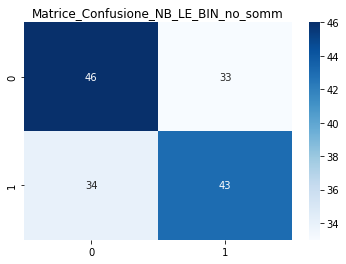

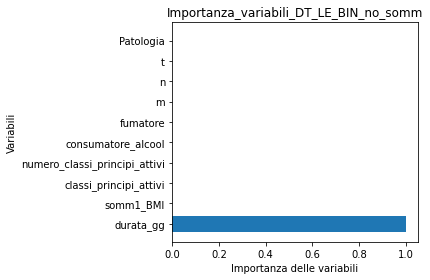

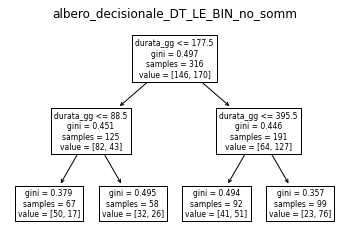

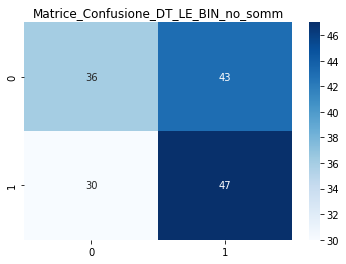

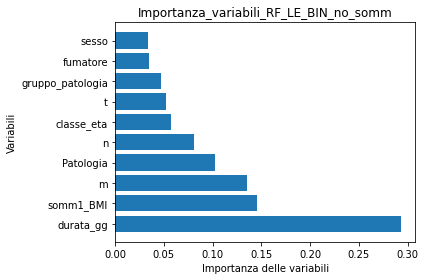

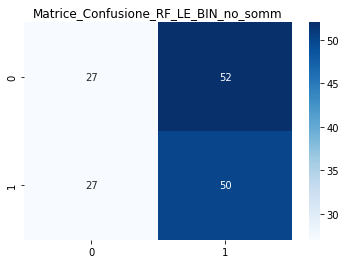

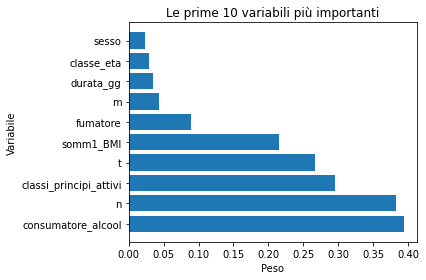

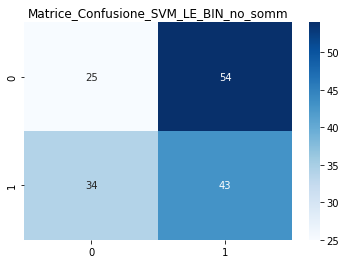

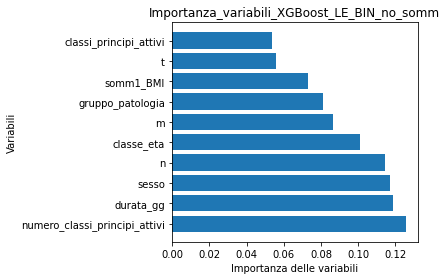

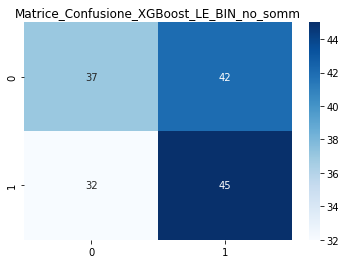

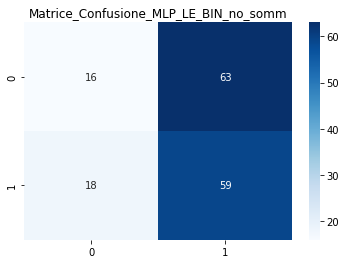

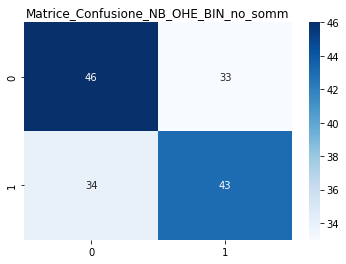

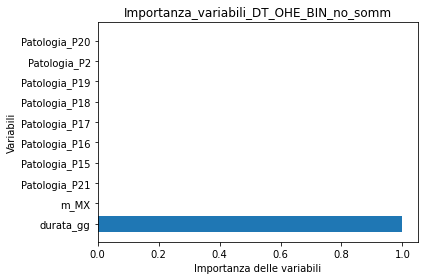

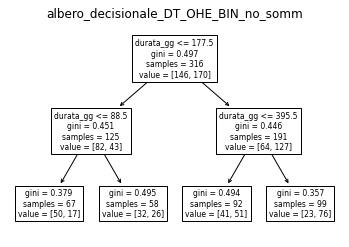

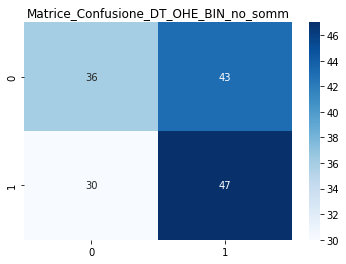

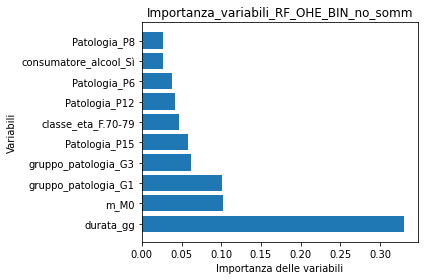

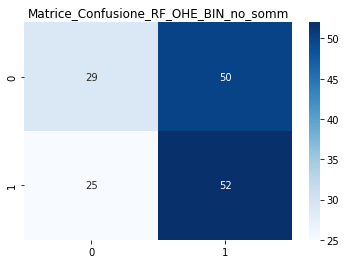

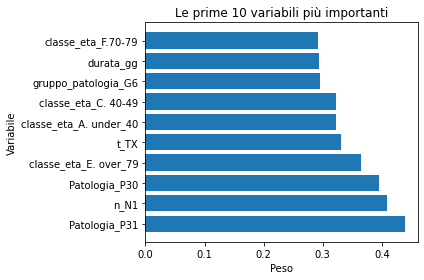

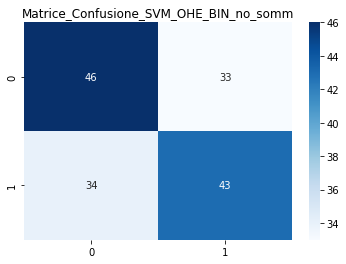

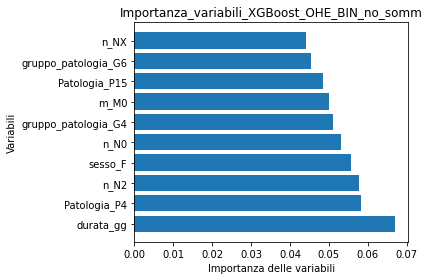

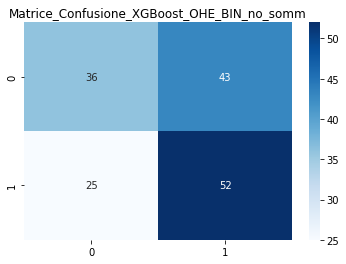

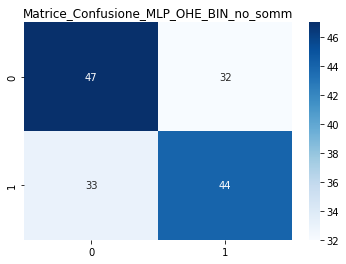

In [11]:
# APPLICAZIONE SU DATASET SENZA COLONNE RELATIVE ALLE SOMMINISTRAZIONI
# esperimento: dataset pre-processato con LE nella versione binaria
scores_le_bin_no_somm = applica_modelli(X_le_bin_no_somm, y_le_bin_no_somm, 'LE_BIN_no_somm', 50)
# esperimento: dataset pre-processato con OHE nella versione binaria
scores_ohe_bin_no_somm = applica_modelli(X_ohe_bin_no_somm, y_ohe_bin_no_somm, 'OHE_BIN_no_somm', 50)
# invio mail per allertare che l'esecuzione è terminata con successo 
invia_mail('Esecuzione terminata con successo!')